In [1]:
#!pip install git+https://github.com/pymc-devs/pymc4
# see pyMC4-install-howto.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import tensorflow as tf
import pandas as pd
import arviz as az
from numba import jit
from scipy.integrate import odeint
import tensorflow_scientific as tfs

%matplotlib inline

In [3]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,170,174,237,273,281,299,349,367,423,444
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,223,243,259,277,304,333,361,377,383,400
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,584,716,847,986,1171,1251,1320,1423,1468,1572
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,370,376,390,428,439,466,501,525,545,564
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,7,8,8,8,10,14,16,17,19


In [4]:
Country = 'Russia'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_Russia_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_Russia_confirmed.shape[0]), dtype=np.int64)
data[0] = data_Russia_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

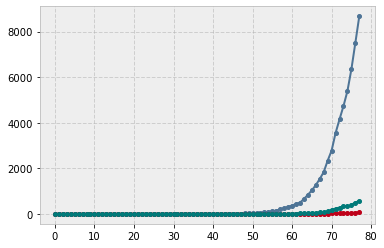

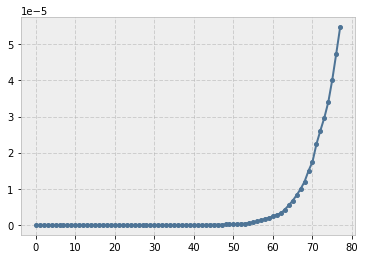

In [5]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

# The SIRX model, ODE

In [6]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

#@jit
def sirx_rhs(x, t, alpha, beta, k0, k):
    #print(x)
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    #return tf.Tensor([dsdt, didt, dxdt, dRdt], dtype=x.dtype)
    return np.array([dsdt, didt, dxdt, dRdt], dtype=x.dtype)


def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max, N + 1)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol

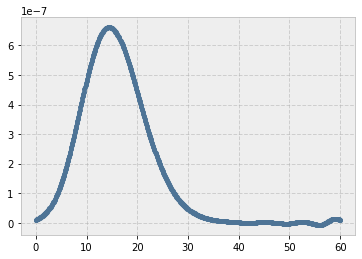

In [7]:
# Test SIRX
t_max = 60
dt = .1
N = int(t_max / dt)
t = np.linspace(0, t_max, N+1)

x0 = np.array([1.0, 1e-8, 0.0, 0.0])
beta = 0.38 #d^{-1}
R0 = 3.07
alpha = R0*beta
k0 = 6e-2
k = 5e-2

params = alpha, beta, k0, k

results = base_sirx_model_odeint(x0, dt, N, params)


plt.plot(t, results[:, 1]);

# Start MCMC

In [8]:
true_vals = data_normed[0][data[0] >= 3]

def sirx_rhs(x, t, alpha, beta, k0, k, istf=True):
    #print(x)
    #res = tf.zeros_like(x)
    #S, I, X, R = x
    S = x[0]
    I = x[1]
    X = x[2]
    R = x[3]
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    #print([dsdt, didt, dxdt, dRdt])
    if istf:
        return tf.stack([ dsdt, didt, dxdt, dRdt ])
    else:
        return [dsdt, didt, dxdt, dRdt]


def Runge_Kutta(rhs, x0, N, h=0.25):
    res = [x0]
    x = x0
    h2 = h/2
    for i in range(1, int(N/h) - 1): # -1 as we already have y0
        k1 = rhs(x)
        k2 = rhs(x + h2*k1)
        k3 = rhs(x + h2*k2)
        k4 = rhs(x + h*k3)
        
        x += h/6*(k1 + 2*k2 + 2*k3 + k4)
        if abs(i*h - np.round(i*h)) < 1e-6: 

            res.append(x)
    
    return tf.stack(res)
    

@pm.model
def sirx_model_odeint(true_vals):
    alpha_MC = yield pm.Uniform("alpha_MC", 1e-5, 2)
    
    beta_MC  = yield pm.Uniform("beta_MC", 1e-5, 2)
    k0_MC    = yield pm.Uniform("k0_MC", 1e-7, 1)
    k_MC     = yield pm.Uniform("k_MC", 1e-7, 1)
    I0_MC    = yield pm.Exponential("I0_MC", 1e-6)
    
    num_days = len(true_vals)
    t = tf.linspace(0.0, float(num_days - 1), num_days)
    #t = np.linspace(float(0), float(num_days - 1), num_days)
    init_vals = tf.stack([1.0 - (I0_MC + true_vals[0]), I0_MC, true_vals[0], 0.0])
    
    func = lambda x, t: sirx_rhs(x, t, alpha_MC, beta_MC, k0_MC, k_MC, istf=True)
    sol = tfs.integrate.odeint(func, init_vals, t)[:, 2]
#    print(sol.shape)
    obs = tf.reshape(sol, [-1])
    
    I_MC     = yield pm.Normal("I_MC", obs, 1e-8, observed=true_vals)
    print(sol, type(sol))
    print('near the end')
    
    print(I_MC, type(I_MC))
    print('near the end 2')
    return I_MC 


@pm.model
def sirx_model(true_vals):
    alpha_MC = yield pm.Uniform("alpha_MC", 1e-5, 2)
    
    beta_MC  = yield pm.Uniform("beta_MC", 1e-5, 2)
    k0_MC    = yield pm.Uniform("k0_MC", 1e-7, 1)
    k_MC     = yield pm.Uniform("k_MC", 1e-7, 1)
    I0_MC    = yield pm.Exponential("I0_MC", 1e-6)
    
    num_days = len(true_vals)
    #t = tf.linspace(float(0), float(num_days - 1), num_days)
    #t = np.linspace(float(0), float(num_days - 1), num_days)
    init_vals = tf.stack([[1.0 - (I0_MC + true_vals[0])], [I0_MC], [true_vals[0]], [0.0]], axis=0)
    init_vals = tf.reshape(init_vals, [-1])
    
    func = lambda x: sirx_rhs(x, None, alpha_MC, beta_MC, k0_MC, k_MC, istf=True)
    print("input vars", init_vals, init_vals.shape)
    sol = Runge_Kutta(func, init_vals, num_days)[:, 2]
    print("sol: ", sol)
    obs = tf.reshape(sol, [-1])
    
    I_MC     = yield pm.Normal("I_MC", obs, 1e-8, observed=true_vals)
    #print(sol, type(sol))
    #print('near the end')
    
    #print(I_MC, type(I_MC))
    #print('near the end 2')
    return I_MC 


In [1]:
trace  = pm.sample(sirx_model(true_vals))

In [ ]:
# with odeint it doesn't work!!!
trace  = pm.sample(sirx_model_odeint(true_vals))

In [ ]:
alpha_samples = trace['alpha_MC']
beta_samples  = trace['beta_MC']
k0_samples    = trace['k0_MC']
k_samples     = trace['k_MC']
I0_samples    = trace['I0_MC']



plt.figure(figsize=(12.5, 6))

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta, k_0$")
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(312)
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#A60628", density=True)
plt.legend();

plt.subplot(313)
plt.hist(k0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k_0$", color="#467821", density=True)
plt.legend();


plt.figure(figsize=(12.5, 6))

plt.subplot(211)
plt.title(r"Posterior distributions of the variables $k, I_0$")
plt.hist(k_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $k$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(I0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $I_0$", color="#A60628", density=True)
plt.legend();


# Further is not relevant (some exmaples)

In [ ]:
1/0

In [ ]:
@pm.model
def test_model():
    alpha = yield pm.Normal(loc=0., scale=1, name='alpha')
    beta  = yield pm.Normal(loc=alpha, scale=1, name='beta')


model = test_model()



In [ ]:
res = pm.inference.sampling.sample(model)

In [ ]:


@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal(loc=0., scale=1, name='mu_alpha')
    sigma_a = yield pm.HalfCauchy(scale=1, name='sigma_alpha')
    mu_b = yield pm.Normal(loc=0., scale=1, name='mu_beta')
    sigma_b = yield pm.HalfCauchy(scale=1, name='sigma_beta')

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal(loc=mu_a, scale=sigma_a, batch_stack=len(data.county.unique()),
                        name='alpha')
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal(loc=mu_b, scale=sigma_b, batch_stack=len(data.county.unique()),
                        name='beta')

    # Model error
    eps = yield pm.HalfCauchy(scale=1, name='eps')

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal(loc=radon_est, scale=eps, observed=data.log_radon, name='y_like')



In [ ]:
def sample(model, init_num_chains=50, num_samples=500, burn_in=500):
    init_num_chains = 50
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)
    for i in range(3):
        step_size_ = []
        for _, x in pm4_trace.items():
            std = tf.math.reduce_std(x, axis=[0, 1])
            step_size_.append(
                std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
        pm4_trace, _ = pm.inference.sampling.sample(
            model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
            step_size=step_size_, xla=True)
        
    num_chains = 5
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

    pm4_trace, sample_stat = pm.inference.sampling.sample(
        model, num_chains=num_chains, num_samples=num_samples, burn_in=burn_in,
        step_size=step_size_, xla=True)
    
    az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)
    
    return az_trace



In [ ]:
res = pm.inference.sampling.sample(
        model, num_chains=50, num_samples=10, burn_in=10, step_size=1., xla=True)